In [96]:
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
#! wget -o  ../../datasets/ https://archive.ics.uci.edu/ml/machine-learning-databases/00280/HIGGS.csv.gz
column_names = 'label, lepton pT, lepton eta, lepton phi, missing energy magnitude, missing energy phi, jet 1 pt, jet 1 eta, jet 1 phi, jet 1 b-tag, jet 2 pt, jet 2 eta, jet 2 phi, jet 2 b-tag, jet 3 pt, jet 3 eta, jet 3 phi, jet 3 b-tag, jet 4 pt, jet 4 eta, jet 4 phi, jet 4 b-tag, m_jj, m_jjj, m_lv, m_jlv, m_bb, m_wbb, m_wwbb'.split(', ')
data = pd.read_csv('../../datasets/HIGGS.csv.gz', header=None, names=column_names)

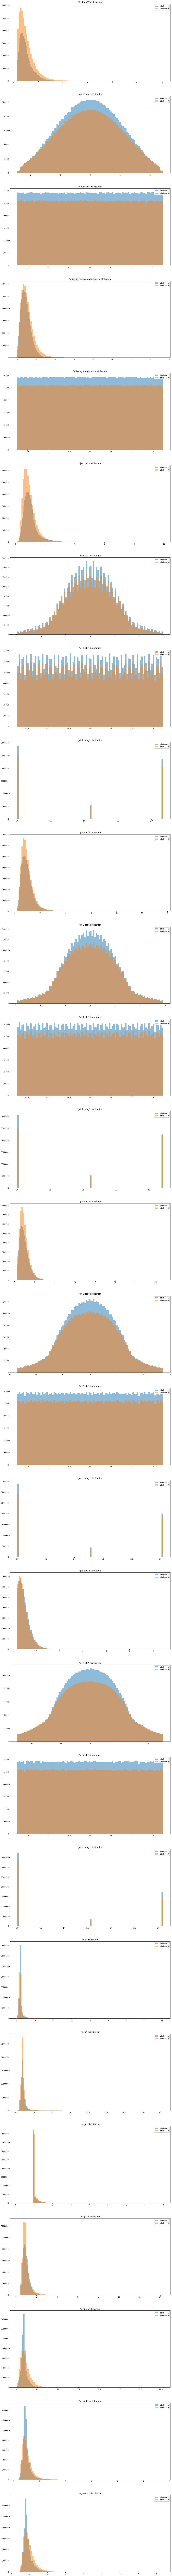

In [116]:
import seaborn as sns
features = list(filter(lambda x: x!='label',column_names))
features_cnt = len(features)
plt.figure(figsize=(17,10*features_cnt))
data_signal, data_bk = data.query('label == 1'), data.query('label == 0')
for i, feature in enumerate(features):
    plt.subplot(features_cnt,1,i+1)
    plt.title('"%s" distribution' % feature)
    plt.hist(data_signal[feature], label='label == 1', bins=100, alpha=0.5)
    plt.hist(data_bk[feature], label='label == 0', bins=100, alpha=0.5)
    plt.legend()

In [4]:
X_data = data.drop('label', 1)
X_data = StandardScaler().fit_transform(X_data)

labels = data["label"]

In [5]:
from sklearn.model_selection import train_test_split
import numpy as np
indx_train, indx_test = train_test_split(np.arange(len(labels), dtype='int32'), stratify=labels, train_size=0.1, test_size=0.1, random_state = 5)

In [6]:
y_train = labels[indx_train]
y_test = labels[indx_test]

X_train = X_data[indx_train]
X_test = X_data[indx_test]

In [7]:
X_good = X_train[np.where(y_train==0)[0]]

In [8]:
X_good.shape, X_train.shape, X_data.shape

((517088, 28), (1100000, 28), (11000000, 28))

In [91]:
import theano
import theano.tensor as T
import lasagne
from lasagne.layers import InputLayer, DenseLayer
from lasagne.nonlinearities import softmax
from lasagne.objectives import categorical_crossentropy

input_size = X_good.shape[1] # features cnt

input_var = T.matrix('input', dtype='float32')
weights_var = T.vector('weights', dtype='float32')
target_var = T.matrix('target', dtype='float32')
lr_var = T.scalar('learning rate')

network = InputLayer(shape=(None, input_size), input_var=input_var)
network = DenseLayer(network, 100)
network = DenseLayer(network, 100)
network = DenseLayer(network, 2, nonlinearity=softmax)
output = lasagne.layers.get_output(network)

loss = (weights_var * categorical_crossentropy(output, target_var)).mean()
params = lasagne.layers.get_all_params(network, trainable=True)
updates = lasagne.updates.rmsprop(loss, params, learning_rate=lr_var)

train_fn = theano.function([input_var, weights_var, target_var, lr_var], [output, loss], updates=updates, allow_input_downcast=True)
predict_fn = theano.function([input_var], [output], allow_input_downcast=True)

In [92]:
def gibbs_sampling(points, f, features_range):
    features_cnt = len(features_range[0])
    new_points = points.copy()
    for feature in range(features_cnt):
        feature_from, feature_to = features_range[0][feature], features_range[1][feature]
        idx_to_replace = np.arange(points.shape[0])
        i = 0
        while len(idx_to_replace.shape) > 0 and idx_to_replace.shape[0] > 0:
            i += 1
            u = np.random.rand(len(idx_to_replace))
            x_new = feature_from * np.ones((len(idx_to_replace,))) + (feature_to - feature_from) * np.random.rand(len(idx_to_replace))
            new_points[idx_to_replace, feature] = x_new
            idx_to_replace = np.argwhere(f(new_points[idx_to_replace,:]) < u).squeeze()
    return new_points

def random_sampling(size, features_range):
    return np.array([features_range[0][i] * np.ones(size) + np.random.rand(size) * (features_range[1][i] - features_range[0][i]) for i in range(len(features_range[0]))]).transpose()

In [93]:
X_min, X_max = np.min(X_data, axis=0), np.max(X_data, axis=0)

random_sampling(1000, [X_min, X_max]).shape

(1000, 28)

In [94]:
from sklearn.metrics import *
from keras.utils import to_categorical

lr = 1e-4
epoches = 1000
batch_size = 10000

X_min, X_max = np.min(X_data, axis=0), np.max(X_data, axis=0)
bad_cnt = X_good.shape[0]
X_bad = random_sampling(bad_cnt, [X_min, X_max])
target = np.concatenate([np.zeros(X_good.shape[0]), np.ones(bad_cnt)])
good_weights = 1e-4 * np.ones(X_good.shape[0])
bad_weights = np.ones(bad_cnt)

def P(x):
    preds = predict_fn(x)[0].squeeze()[:, 1]
    return 1 - np.exp(-preds / (1 - preds))

for epoch in range(epoches):
#     if epoch % 30 == 0 and epoch > 0:
#         lr /= 3
    print('Epoch: %d' % epoch)
    X_bad = gibbs_sampling(X_bad, P, [X_min, X_max]) # Metropolis-Hastings sampling
#     X_bad = random_sampling(bad_cnt, [X_min, X_max])
    X_mix = np.concatenate([X_good, X_bad])
    eps = 1e-1 # Metropolis-Hastings reweighting
    bad_weights = 1000./(eps + P(X_bad)) # Metropolis-Hastings reweighting
    bad_weights /= max(bad_weights) # Metropolis-Hastings reweighting
    weights = np.concatenate([good_weights, bad_weights])
    indices = np.arange(len(weights))
    np.random.shuffle(indices)
    for i in range(int(len(indices)/batch_size)):
        batch_idx = indices[range(batch_size*i,min(batch_size*(i+1), len(indices)))]
        _, loss_value = train_fn(X_mix[batch_idx], weights[batch_idx], to_categorical(target[batch_idx]), lr)
    y_pred = predict_fn(X_test)[0].squeeze()[:, 1]
    print ("recall_score ",recall_score(y_test, np.round(y_pred)))
    # print ("accuracy score", accuracy_score(y_test_rescale, y_pred))
    print ("precision_score ",precision_score(y_test, np.round(y_pred)))
    print ("f1_score ",f1_score(y_test, np.round(y_pred)))
    print ("confusion_matrix ")
    print (confusion_matrix(y_test, np.round(y_pred)))
    acc_test = accuracy_score(y_test, np.round(y_pred))
    
    print('Loss: %.2f, Accuracy (test): %.2f' % (loss_value, acc_test))

Epoch: 0
('recall_score ', 0.8122855593983311)
('precision_score ', 0.5275301316232194)
('f1_score ', 0.6396478425153026)
confusion_matrix 
[[ 93017 424071]
 [109421 473491]]
Loss: 0.00, Accuracy (test): 0.52
Epoch: 1
('recall_score ', 0.8538733119235836)
('precision_score ', 0.527522736450072)
('f1_score ', 0.6521483634152908)
confusion_matrix 
[[ 71292 445796]
 [ 85179 497733]]
Loss: 0.00, Accuracy (test): 0.52
Epoch: 2
('recall_score ', 0.8674516908212561)
('precision_score ', 0.5275178343776277)
('f1_score ', 0.656066285468136)
confusion_matrix 
[[ 64194 452894]
 [ 77264 505648]]
Loss: 0.00, Accuracy (test): 0.52
Epoch: 3
('recall_score ', 0.8771015178963548)
('precision_score ', 0.5276807038040842)
('f1_score ', 0.6589342306894236)
confusion_matrix 
[[ 59455 457633]
 [ 71639 511273]]
Loss: 0.00, Accuracy (test): 0.52
Epoch: 4
('recall_score ', 0.8825843351998244)
('precision_score ', 0.5277276289497331)
('f1_score ', 0.660512213471923)
confusion_matrix 
[[ 56681 460407]
 [ 68443 5

('precision_score ', 0.5273872137571394)
('f1_score ', 0.6505436504857943)
confusion_matrix 
[[ 73729 443359]
 [ 88169 494743]]
Loss: 0.00, Accuracy (test): 0.52
Epoch: 40
('recall_score ', 0.8467161424022837)
('precision_score ', 0.5273465087778719)
('f1_score ', 0.6499162192323773)
confusion_matrix 
[[ 74716 442372]
 [ 89351 493561]]
Loss: 0.00, Accuracy (test): 0.52
Epoch: 41
('recall_score ', 0.8444756669960475)
('precision_score ', 0.5272727662231801)
('f1_score ', 0.6491992411468784)
confusion_matrix 
[[ 75756 441332]
 [ 90657 492255]]
Loss: 0.00, Accuracy (test): 0.52
Epoch: 42
('recall_score ', 0.8423775801493193)
('precision_score ', 0.5272770225286172)
('f1_score ', 0.6485815349907408)
confusion_matrix 
[[ 76860 440228]
 [ 91880 491032]]
Loss: 0.00, Accuracy (test): 0.52
Epoch: 43
('recall_score ', 0.8402812088274044)
('precision_score ', 0.5272511593260624)
('f1_score ', 0.6479396785501687)
confusion_matrix 
[[ 77910 439178]
 [ 93102 489810]]
Loss: 0.00, Accuracy (test): 0.5

('f1_score ', 0.6205670336575412)
confusion_matrix 
[[120904 396184]
 [142445 440467]]
Loss: 0.00, Accuracy (test): 0.51
Epoch: 79
('recall_score ', 0.7533229715634607)
('precision_score ', 0.5264627495363249)
('f1_score ', 0.6197857600057586)
confusion_matrix 
[[122112 394976]
 [143791 439121]]
Loss: 0.00, Accuracy (test): 0.51
Epoch: 80
('recall_score ', 0.7507548309178744)
('precision_score ', 0.52642506492741)
('f1_score ', 0.618888790680408)
confusion_matrix 
[[123399 393689]
 [145288 437624]]
Loss: 0.00, Accuracy (test): 0.51
Epoch: 81
('recall_score ', 0.7479550944224858)
('precision_score ', 0.52637666321779)
('f1_score ', 0.6179020564753002)
confusion_matrix 
[[124791 392297]
 [146920 435992]]
Loss: 0.00, Accuracy (test): 0.51
Epoch: 82
('recall_score ', 0.7453577898550725)
('precision_score ', 0.5264000891714806)
('f1_score ', 0.6170300393101411)
confusion_matrix 
[[126190 390898]
 [148434 434478]]
Loss: 0.00, Accuracy (test): 0.51
Epoch: 83
('recall_score ', 0.74271073506807

[[175399 341689]
 [204510 378402]]
Loss: 0.00, Accuracy (test): 0.50
Epoch: 118
('recall_score ', 0.6464286204435661)
('precision_score ', 0.5254555418741538)
('f1_score ', 0.5796980827291783)
confusion_matrix 
[[176786 340302]
 [206101 376811]]
Loss: 0.00, Accuracy (test): 0.50
Epoch: 119
('recall_score ', 0.6438604797979798)
('precision_score ', 0.525503396112288)
('f1_score ', 0.5786921859424521)
confusion_matrix 
[[178203 338885]
 [207598 375314]]
Loss: 0.00, Accuracy (test): 0.50
Epoch: 120
('recall_score ', 0.6409972688844972)
('precision_score ', 0.5254487081228019)
('f1_score ', 0.57749984737355)
confusion_matrix 
[[179636 337452]
 [209267 373645]]
Loss: 0.00, Accuracy (test): 0.50
Epoch: 121
('recall_score ', 0.638386240118577)
('precision_score ', 0.5254690591140865)
('f1_score ', 0.5764500400825663)
confusion_matrix 
[[181038 336050]
 [210789 372123]]
Loss: 0.00, Accuracy (test): 0.50
Epoch: 122
('recall_score ', 0.6356516935660957)
('precision_score ', 0.5254612493795646)
(

[[227588 289500]
 [263919 318993]]
Loss: 0.00, Accuracy (test): 0.50
Epoch: 157
('recall_score ', 0.5445984985726834)
('precision_score ', 0.5241819899077964)
('f1_score ', 0.5341952398260705)
confusion_matrix 
[[228925 288163]
 [265459 317453]]
Loss: 0.00, Accuracy (test): 0.50
Epoch: 158
('recall_score ', 0.5420046250548968)
('precision_score ', 0.5241989540609777)
('f1_score ', 0.5329531116104261)
confusion_matrix 
[[230317 286771]
 [266971 315941]]
Loss: 0.00, Accuracy (test): 0.50
Epoch: 159
('recall_score ', 0.5396303387132192)
('precision_score ', 0.524121027524281)
('f1_score ', 0.5317626215795644)
confusion_matrix 
[[231484 285604]
 [268355 314557]]
Loss: 0.00, Accuracy (test): 0.50
Epoch: 160
('recall_score ', 0.5373435441370223)
('precision_score ', 0.524126898601264)
('f1_score ', 0.5306529394175293)
confusion_matrix 
[[232701 284387]
 [269688 313224]]
Loss: 0.00, Accuracy (test): 0.50
Epoch: 161
('recall_score ', 0.5350035682916118)
('precision_score ', 0.5241203597886444)

[[274747 242341]
 [317426 265486]]
Loss: 0.00, Accuracy (test): 0.49
Epoch: 196
('recall_score ', 0.4533034145805885)
('precision_score ', 0.5228182435146328)
('f1_score ', 0.48558556820197024)
confusion_matrix 
[[275917 241171]
 [318676 264236]]
Loss: 0.00, Accuracy (test): 0.49
Epoch: 197
('recall_score ', 0.45117444828722003)
('precision_score ', 0.5228185824786843)
('f1_score ', 0.4843615468555037)
confusion_matrix 
[[277050 240038]
 [319917 262995]]
Loss: 0.00, Accuracy (test): 0.49
Epoch: 198
('recall_score ', 0.4489048089591568)
('precision_score ', 0.5227731317401397)
('f1_score ', 0.4830311834884231)
confusion_matrix 
[[278214 238874]
 [321240 261672]]
Loss: 0.00, Accuracy (test): 0.49
Epoch: 199
('recall_score ', 0.44673981664470797)
('precision_score ', 0.522632489473494)
('f1_score ', 0.48171531422208)
confusion_matrix 
[[279232 237856]
 [322502 260410]]
Loss: 0.00, Accuracy (test): 0.49
Epoch: 200
('recall_score ', 0.4447086352657005)
('precision_score ', 0.522476111006975

('f1_score ', 0.43785181895055236)
confusion_matrix 
[[313945 203143]
 [362590 220322]]
Loss: 0.00, Accuracy (test): 0.49
Epoch: 235
('recall_score ', 0.3764581960913483)
('precision_score ', 0.5202611713830514)
('f1_score ', 0.4368291556518139)
confusion_matrix 
[[314738 202350]
 [363470 219442]]
Loss: 0.00, Accuracy (test): 0.49
Epoch: 236
('recall_score ', 0.3749142237593325)
('precision_score ', 0.5202687260746186)
('f1_score ', 0.43579057357762163)
confusion_matrix 
[[315574 201514]
 [364370 218542]]
Loss: 0.00, Accuracy (test): 0.49
Epoch: 237
('recall_score ', 0.3732433025911287)
('precision_score ', 0.5201864913329348)
('f1_score ', 0.43463095882584435)
confusion_matrix 
[[316406 200682]
 [365344 217568]]
Loss: 0.00, Accuracy (test): 0.49
Epoch: 238
('recall_score ', 0.37150376043039085)
('precision_score ', 0.5200724317470077)
('f1_score ', 0.4334096531185705)
confusion_matrix 
[[317250 199838]
 [366358 216554]]
Loss: 0.00, Accuracy (test): 0.49
Epoch: 239
('recall_score ', 0.

('precision_score ', 0.5173568143490107)
('f1_score ', 0.39257946203761374)
confusion_matrix 
[[345087 172001]
 [398540 184372]]
Loss: 0.00, Accuracy (test): 0.48
Epoch: 274
('recall_score ', 0.3147730703776899)
('precision_score ', 0.5172204807865777)
('f1_score ', 0.3913662036721043)
confusion_matrix 
[[345821 171267]
 [399427 183485]]
Loss: 0.00, Accuracy (test): 0.48
Epoch: 275
('recall_score ', 0.31344182312252966)
('precision_score ', 0.5171775442211723)
('f1_score ', 0.3903233628108734)
confusion_matrix 
[[346516 170572]
 [400203 182709]]
Loss: 0.00, Accuracy (test): 0.48
Epoch: 276
('recall_score ', 0.3117537467061924)
('precision_score ', 0.5169809281048726)
('f1_score ', 0.3889561911937194)
confusion_matrix 
[[347301 169787]
 [401187 181725]]
Loss: 0.00, Accuracy (test): 0.48
Epoch: 277
('recall_score ', 0.3103024127140975)
('precision_score ', 0.5168591659570577)
('f1_score ', 0.3877903673609398)
confusion_matrix 
[[348009 169079]
 [402033 180879]]
Loss: 0.00, Accuracy (test

('recall_score ', 0.2677745525911287)
('precision_score ', 0.5135216049585798)
('f1_score ', 0.35199972938536656)
confusion_matrix 
[[369219 147869]
 [426823 156089]]
Loss: 0.00, Accuracy (test): 0.48
Epoch: 313
('recall_score ', 0.26659427151954324)
('precision_score ', 0.5133404905442233)
('f1_score ', 0.35093610587633534)
confusion_matrix 
[[369764 147324]
 [427511 155401]]
Loss: 0.00, Accuracy (test): 0.48
Epoch: 314
('recall_score ', 0.26498682476943347)
('precision_score ', 0.5133058620231291)
('f1_score ', 0.3495324903375302)
confusion_matrix 
[[370632 146456]
 [428448 154464]]
Loss: 0.00, Accuracy (test): 0.48
Epoch: 315
('recall_score ', 0.26384085419411507)
('precision_score ', 0.5131733489936469)
('f1_score ', 0.3485035259141091)
confusion_matrix 
[[371188 145900]
 [429116 153796]]
Loss: 0.00, Accuracy (test): 0.48
Epoch: 316
('recall_score ', 0.26287672924901184)
('precision_score ', 0.5131473196345808)
('f1_score ', 0.3476554346543728)
confusion_matrix 
[[371706 145382]
 [

('recall_score ', 0.22924901185770752)
('precision_score ', 0.5092042540381736)
('f1_score ', 0.3161596744524425)
confusion_matrix 
[[388287 128801]
 [449280 133632]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 352
('recall_score ', 0.22841355127360563)
('precision_score ', 0.5090535797579085)
('f1_score ', 0.31533537170235393)
confusion_matrix 
[[388679 128409]
 [449767 133145]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 353
('recall_score ', 0.22784571256038647)
('precision_score ', 0.5089692542930173)
('f1_score ', 0.31477770575416036)
confusion_matrix 
[[388955 128133]
 [450098 132814]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 354
('recall_score ', 0.22714063186209926)
('precision_score ', 0.5089076030764382)
('f1_score ', 0.31409244404168984)
confusion_matrix 
[[389320 127768]
 [450509 132403]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 355
('recall_score ', 0.22626056763285024)
('precision_score ', 0.5087799157498418)
('f1_score ', 0.3132258294345358)
confusion_matrix 
[[389750 127338]


('recall_score ', 0.20020174571805008)
('precision_score ', 0.5056347731142683)
('f1_score ', 0.2868340233817658)
confusion_matrix 
[[402989 114099]
 [466212 116700]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 391
('recall_score ', 0.199512104743083)
('precision_score ', 0.505535777160518)
('f1_score ', 0.2861096657773251)
confusion_matrix 
[[403337 113751]
 [466614 116298]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 392
('recall_score ', 0.19887392951251648)
('precision_score ', 0.5054413226599697)
('f1_score ', 0.2854378111657729)
confusion_matrix 
[[403658 113430]
 [466986 115926]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 393
('recall_score ', 0.19821859903381642)
('precision_score ', 0.5054020243375412)
('f1_score ', 0.28475595480142446)
confusion_matrix 
[[404014 113074]
 [467368 115544]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 394
('recall_score ', 0.19764046717171718)
('precision_score ', 0.5053115898803466)
('f1_score ', 0.28414460897960797)
confusion_matrix 
[[404303 112785]
 [46

('recall_score ', 0.17647775307422048)
('precision_score ', 0.5017240958860683)
('f1_score ', 0.26111147069536406)
confusion_matrix 
[[414924 102164]
 [480041 102871]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 430
('recall_score ', 0.17602657004830918)
('precision_score ', 0.5017211703958692)
('f1_score ', 0.2606168976307555)
confusion_matrix 
[[415184 101904]
 [480304 102608]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 431
('recall_score ', 0.17537123956960912)
('precision_score ', 0.5015946850374383)
('f1_score ', 0.25988097326347315)
confusion_matrix 
[[415512 101576]
 [480686 102226]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 432
('recall_score ', 0.17458552920509443)
('precision_score ', 0.5014684143096482)
('f1_score ', 0.25900042247140687)
confusion_matrix 
[[415916 101172]
 [481144 101768]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 433
('recall_score ', 0.1739782334211682)
('precision_score ', 0.5013124267784496)
('f1_score ', 0.2583108446286275)
confusion_matrix 
[[416205 100883]
 

[[424289  92799]
 [490601  92311]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 468
('recall_score ', 0.15801527503293808)
('precision_score ', 0.4986303891210671)
('f1_score ', 0.23998092846088512)
confusion_matrix 
[[424473  92615]
 [490803  92109]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 469
('recall_score ', 0.15768760979358806)
('precision_score ', 0.49854912106567734)
('f1_score ', 0.23959347463712868)
confusion_matrix 
[[424635  92453]
 [490994  91918]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 470
('recall_score ', 0.15732734958278435)
('precision_score ', 0.4985810436125216)
('f1_score ', 0.23918106539740494)
confusion_matrix 
[[424858  92230]
 [491204  91708]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 471
('recall_score ', 0.15688817523056653)
('precision_score ', 0.498563492539429)
('f1_score ', 0.23867119553515853)
confusion_matrix 
[[425109  91979]
 [491460  91452]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 472
('recall_score ', 0.1564318456302152)
('precision_score ', 0.4985347

('precision_score ', 0.49577596903366755)
('f1_score ', 0.22228965612701354)
confusion_matrix 
[[432156  84932]
 [499403  83509]]
Loss: 0.00, Accuracy (test): 0.47
Epoch: 507


KeyboardInterrupt: 

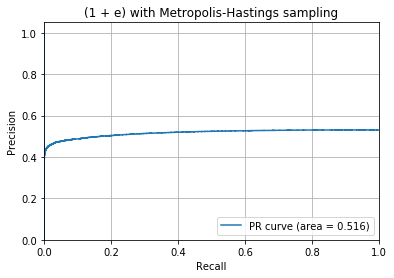

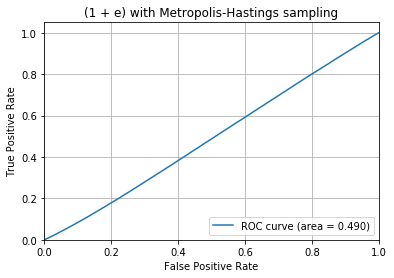

In [100]:

Score = y_pred

precision, recall, _ = precision_recall_curve(y_test, Score)
pr_auc = auc(recall, precision)

plt.figure()
plt.title('(1 + e) with Metropolis-Hastings sampling')
plt.plot(recall, precision, label='PR curve (area = %0.3f)' % pr_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

fpr, tpr, _ = roc_curve(y_test, Score)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.title('(1 + e) with Metropolis-Hastings sampling')
plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [98]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import *
# from sklearn.linear_model import 
clf = IsolationForest(n_estimators=500,max_samples=1500,contamination=0.03,random_state=10)
clf.fit(X_good)
y_pred = clf.predict(X_test)
y_test_rescale = np.where(y_test == 0, np.ones((y_test.shape)), -np.ones((y_test.shape)))
print ("recall_score ",recall_score(-y_test_rescale, np.round(-y_pred)))
print ("accuracy score", accuracy_score(y_test_rescale, y_pred))
print ("precision_score ",precision_score(-y_test_rescale, np.round(-y_pred)))
print ("f1_score ",f1_score(-y_test_rescale, np.round(-y_pred)))
print ("confusion_matrix ")
print (confusion_matrix(-y_test_rescale, np.round(-y_pred)))

KeyboardInterrupt: 